# Thermo-mechanical NTFA - Generate input files

Felix Fritzen <fritzen@simtech.uni-stuttgart.de>,
Julius Herb <julius.herb@mib.uni-stuttgart.de>,
Shadi Sharba <shadi.sharba@isc.fraunhofer.de>

University of Stuttgart, Institute of Applied Mechanics, Chair for Data Analytics in Engineering

> **Funding acknowledgment**
> The IGF-Project no.: 21.079 N / DVS-No.: 06.3341 of the
> “Forschungsvereinigung Schweißen und verwandte Verfahren e.V.” of the
> German Welding Society (DVS), Aachener Str. 172, 40223 Düsseldorf, Germany,
> was funded by the Federal Ministry for Economic Affairs and Climate Action (BMWK)
> via the German Federation of Industrial Research Associations (AiF) in accordance
> with the policy to support the Industrial Collective Research (IGF)
> on the orders of the German Bundestag.
>
> Felix Fritzen is funded by the German Research Foundation (DFG) --
> 390740016 (EXC-2075); 406068690 (FR2702/8-1); 517847245 (FR2702/10-1).

## Imports

In [1]:
import os
import sys
from itertools import count

import h5py
import matplotlib.pyplot as plt
import numpy as np

data_path = "../data"

## Load H5 file with validation simulations

While the NTFA is trained based on snapshots at 10 temperature points,
this data set contains snapshots at 100 temperature points.

In [2]:
file_name = os.path.join(
    data_path, "validation", "simple_3d_rve_B1-B6_16x16x16_100samples_fix.h5"
)
group_name = "/ms_9p/dset0_sim"
suffix = "_fix16_N24_100s"
prefix = os.path.join(data_path, "loadcases")
N_modes = 24

# open the file an get the keys --> extract temperatures!
F = h5py.File(file_name, "r")
keylist = F[group_name].keys()

temp_list = []
temp_str_list = []
for k in keylist:
    if k[:13] == "hom_response_":
        temp_list.append(float(k[13:20]))
        temp_str_list.append(k[13:20])

# get loadings:
loadcases = np.array(F[group_name + "/loadcases_" + temp_str_list[0]])[-1, :, :].T
# find proportional loadings, figure direction and amplitude:
fans_S = []
fans_S0 = []
fans_S1 = []
for t_str in temp_str_list:
    fans_S.append(
        np.transpose(np.array(F[group_name + "/hom_response_" + t_str]), axes=(2, 0, 1))
    )
    fans_S0.append(
        np.transpose(
            np.array(F[group_name + "/hom_response0_" + t_str]), axes=(2, 0, 1)
        )
    )
    fans_S1.append(
        np.transpose(
            np.array(F[group_name + "/hom_response1_" + t_str]), axes=(2, 0, 1)
        )
    )
F.close()

## Generate input files (*.inp) for FE simulation on macroscale

The thermo-mechanical NTFA is used as effective material model in the FE simulation on macroscale.

In [3]:
ntfa_S = []
ntfa_S0 = []
ntfa_S1 = []
modefn = os.path.join(data_path, "ntfa", "ms9p_fix_ntfa16_B1-6_10s_N24.h5")
orig_stdout = sys.stdout
amplitudes = np.ones(loadcases.shape[0])
for n, d, amp in zip(count(), loadcases, amplitudes):
    for T, T_str in zip(temp_list, temp_str_list):
        f = open(os.path.join(prefix, f"loadcase{n + 1}_T{T_str}{suffix}.inp"), "w")
        sys.stdout = f
        print(f'output="loadcase{n + 1}_T{T_str}{suffix}.h5";')
        print(f'modes="{modefn}";')
        print(f"epsilon=[{d[0]}, {d[1]}, {d[2]}, {d[3]}, {d[4]}, {d[5]}];")
        print(f"amplitude={amp};")
        print("totaltime=1;")
        print("deltat=0.1;")
        print(f"tstart={T};")
        print(f"tend={T};")
        print("hardeningmodulus=500000.0;")
        # print("hardeningmodulus=20000000.0;")
        print("elastic=false;")
        print("relaxthermo=false;")
        print("linhardening=true;")
        f.close()
        sys.stdout = orig_stdout

## Post-process results of FE simulation on macroscale

In [4]:
ntfa_eps = np.zeros(
    (len(temp_list), fans_S[0].shape[0], fans_S[0].shape[1], fans_S[0].shape[2])
)
ntfa_S = np.zeros(
    (len(temp_list), fans_S[0].shape[0], fans_S[0].shape[1], fans_S[0].shape[2])
)
ntfa_S0 = np.zeros(
    (len(temp_list), fans_S[0].shape[0], fans_S[0].shape[1], fans_S[0].shape[2])
)
ntfa_S1 = np.zeros(
    (len(temp_list), fans_S[0].shape[0], fans_S[0].shape[1], fans_S[0].shape[2])
)
ntfa_q = np.zeros((len(temp_list), fans_S[0].shape[0], fans_S[0].shape[1]))
ntfa_xi = np.zeros((len(temp_list), fans_S[0].shape[0], fans_S[0].shape[1], N_modes))
ct = 0
print(ntfa_S1.shape)
for i_T, (T, T_str) in enumerate(zip(temp_list, temp_str_list)):
    for n, d, amp in zip(count(), loadcases, amplitudes):
        ntfa_fname = os.path.join(prefix, f"loadcase{n + 1}_T{T_str}{suffix}.h5")
        # print(ntfa_fname)
        F_ntfa = h5py.File(ntfa_fname, "r")
        # get references values:

        ntfa_eps[i_T, n, :, :] = np.array(F_ntfa["/eps"])
        ntfa_S[i_T, n, :, :] = np.array(F_ntfa["/sig"])
        ntfa_S0[i_T, n, :, :] = np.array(F_ntfa["/sig0"])
        ntfa_S1[i_T, n, :, :] = np.array(F_ntfa["/sig1"])
        ntfa_q[i_T, n, :] = np.array(F_ntfa["/sdv"][:, 0])
        ntfa_xi[i_T, n, :] = np.array(F_ntfa["/sdv"][:, 1 : (1 + N_modes)])

        F_ntfa.close()

print(ntfa_S1[0][5])
print(ntfa_S1[9][5])

(100, 6, 11, 6)
[[-3.94059291e+04 -3.94059291e+04 -3.94059291e+04  2.14816003e+01
   2.14816003e+01  2.14816003e+01]
 [ 8.65907872e+04  8.65907872e+04  8.65907872e+04  2.59256527e+02
   2.59256527e+02  2.59256527e+02]
 [ 2.12587503e+05  2.12587503e+05  2.12587503e+05  4.97031453e+02
   4.97031453e+02  4.97031453e+02]
 [ 3.38584220e+05  3.38584220e+05  3.38584220e+05  7.34806380e+02
   7.34806380e+02  7.34806380e+02]
 [ 4.64580936e+05  4.64580936e+05  4.64580936e+05  9.72581306e+02
   9.72581306e+02  9.72581306e+02]
 [ 5.90577652e+05  5.90577652e+05  5.90577652e+05  1.21035623e+03
   1.21035623e+03  1.21035623e+03]
 [ 7.16574368e+05  7.16574368e+05  7.16574368e+05  1.44813116e+03
   1.44813116e+03  1.44813116e+03]
 [ 8.42571085e+05  8.42571085e+05  8.42571085e+05  1.68590609e+03
   1.68590609e+03  1.68590609e+03]
 [ 9.68567801e+05  9.68567801e+05  9.68567801e+05  1.92368101e+03
   1.92368101e+03  1.92368101e+03]
 [ 1.09456452e+06  1.09456452e+06  1.09456452e+06  2.16145594e+03
   2.1614

## Compute error of stresses

Overall stress: $S$,
Stress in phase 0: $S_0$,
Stress in phase 1: $S_1$

In [5]:
err = np.linalg.norm(fans_S - ntfa_S, axis=(2, 3)) / np.linalg.norm(fans_S, axis=(2, 3))
err0 = np.linalg.norm(fans_S0 - ntfa_S0, axis=(2, 3)) / np.linalg.norm(
    fans_S, axis=(2, 3)
)
err1 = np.linalg.norm(fans_S1 - ntfa_S1, axis=(2, 3)) / np.linalg.norm(
    fans_S, axis=(2, 3)
)

## Plot stresses (NTFA vs. reference)

### Incremenent $i_T = 9$; all loading directions $1 \leq n \leq 6$

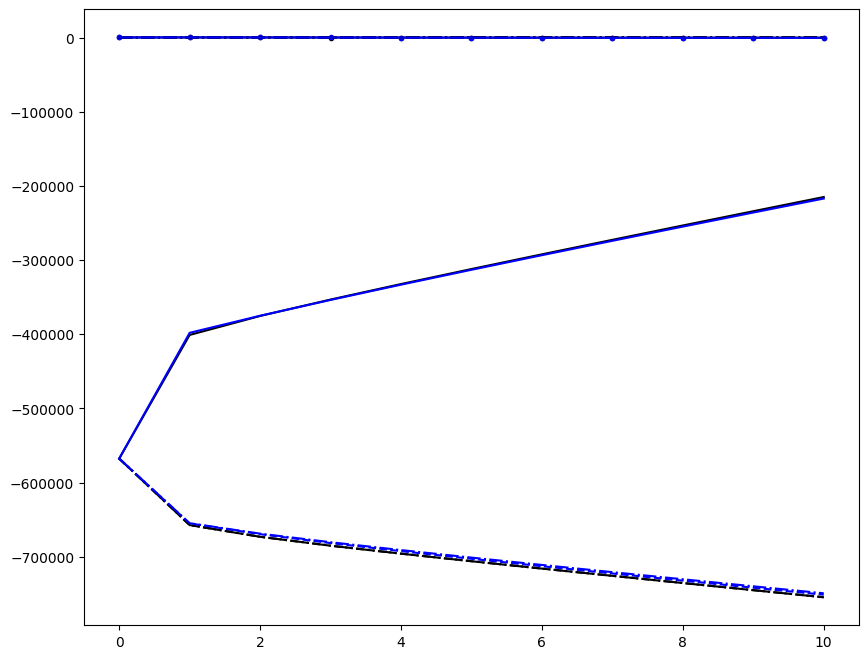

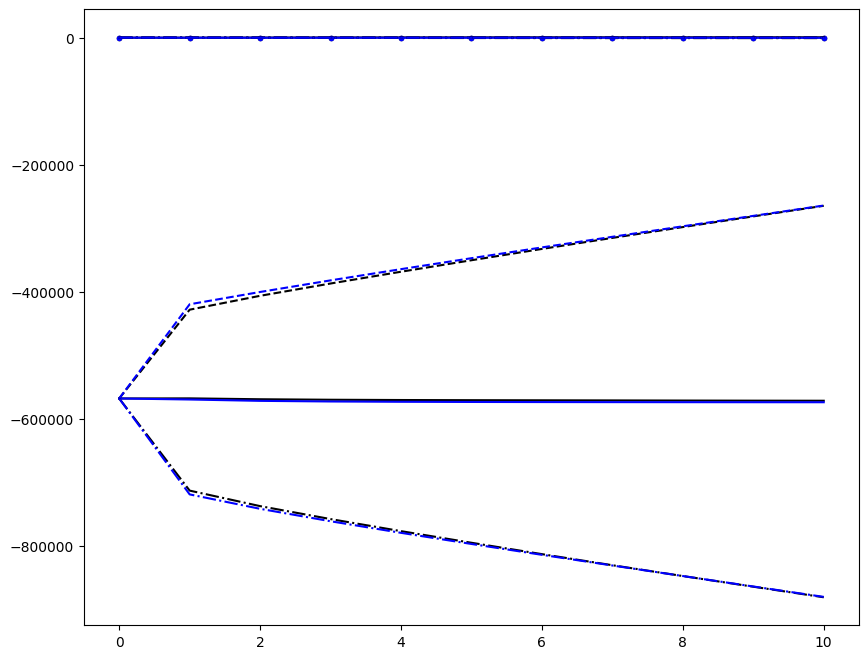

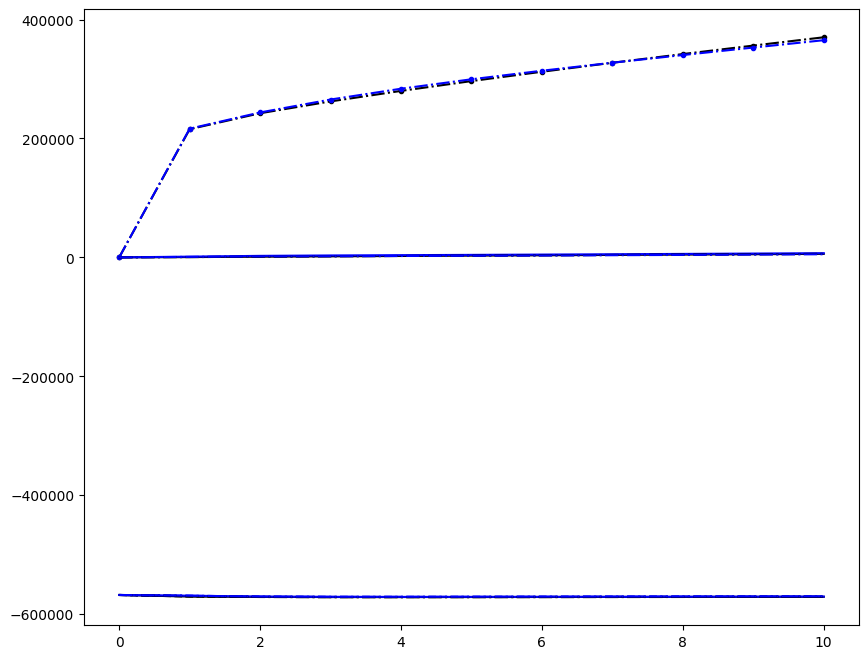

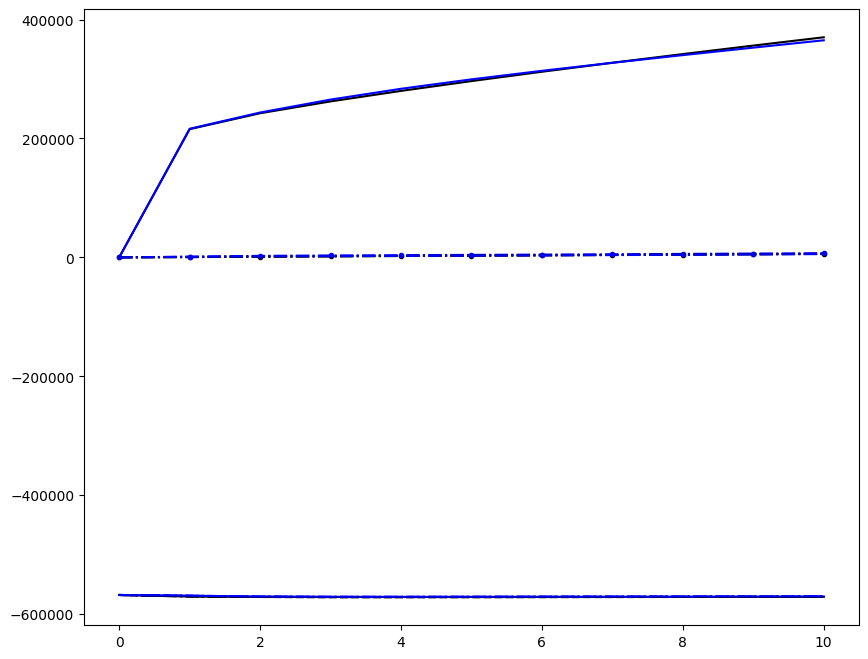

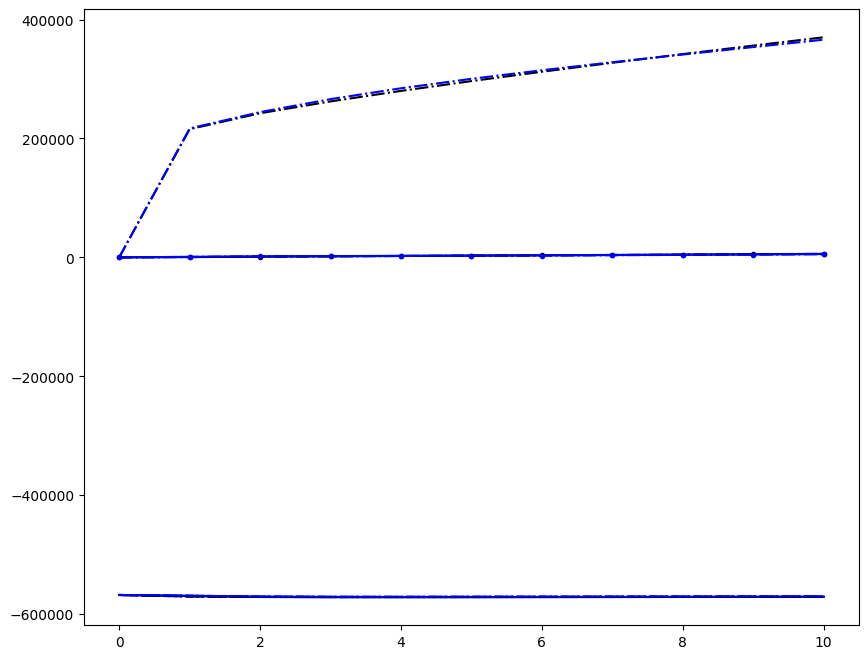

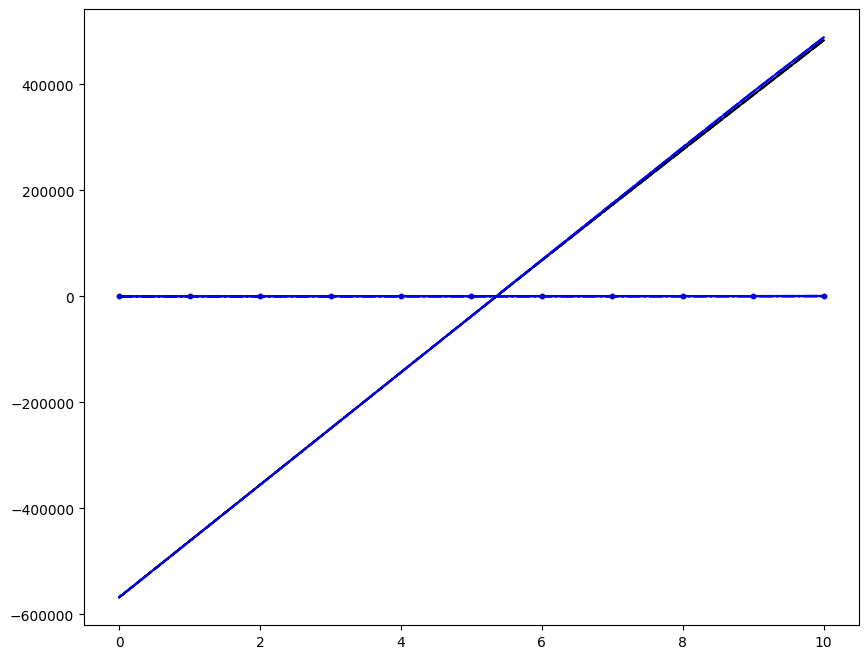

In [6]:
i_T = 9
for n in range(6):
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
    # fig, ax2 = plt.subplots(1,1,figsize=(10,8))
    # fig, ax3 = plt.subplots(1,1,figsize=(10,8))
    # for i, dp in zip( (0,),  ('--',) ):
    for i, dp in enumerate(("-", "--", "-.", "-..", "-", "-.")):
        ax1.plot(fans_S[i_T][n][:, i], dp, color="black")
        # ax1.plot( (fans_S[i_T][n][:,i]-ntfa_S[i_T][n][:,i])/1e3, dp, color='black' )
        # print(fans_S[i_T][n][:,i]-ntfa_S[i_T][n][:,i])
        ax1.plot(ntfa_S[i_T][n][:, i], dp, color="blue")
        # ax2.plot( fans_S0[i_T][n][:,i], dp, color='black' )
        # ax2.plot( ntfa_S0[i_T][n][:,i], dp, color='blue' )
        # ax1.plot( fans_S1[i_T][n][:,i], dp, color='black' )
        # ax1.plot( ntfa_S1[i_T][n][:,i], dp, color='blue' )

### Loading direction $n = 5$; all increments $0 \leq i_T \leq 9$

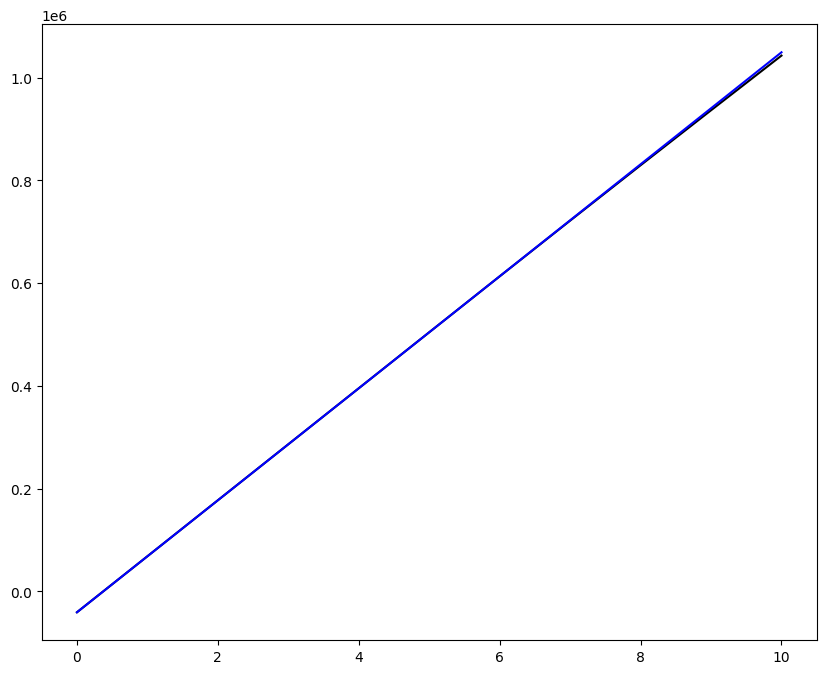

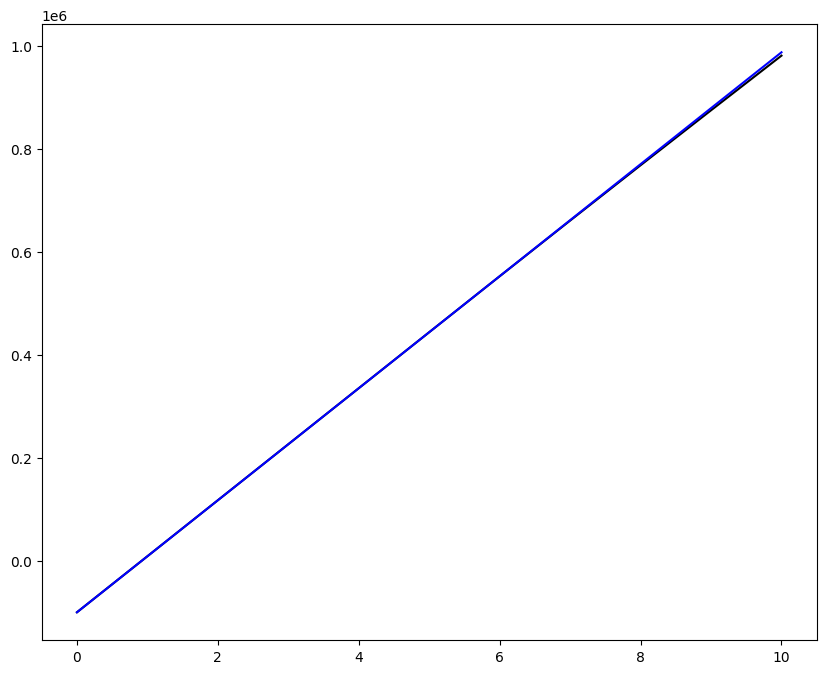

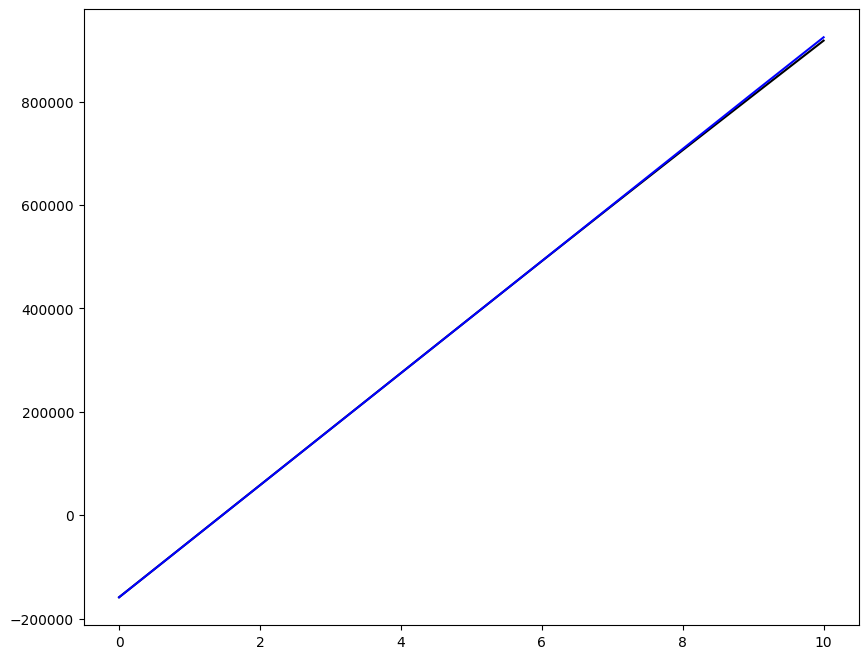

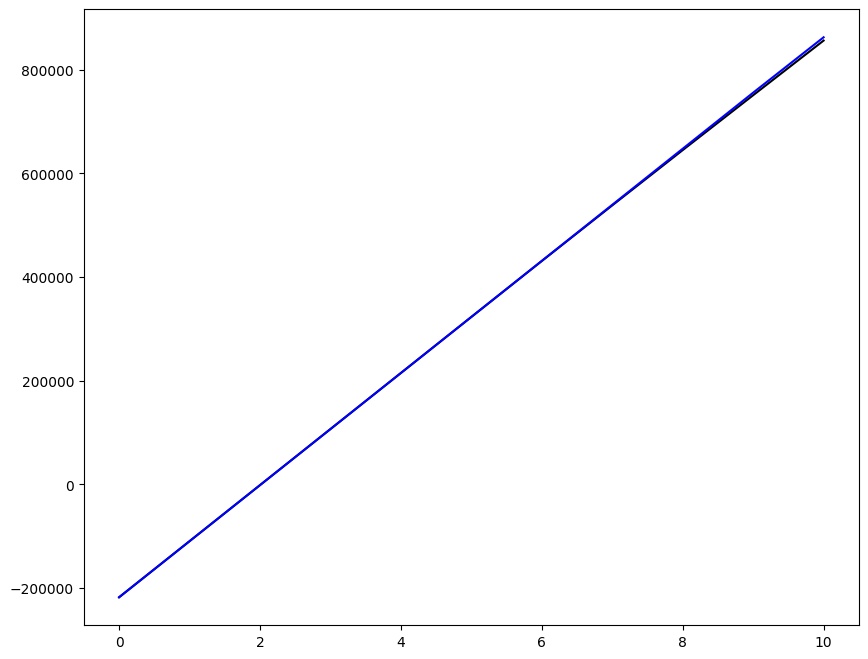

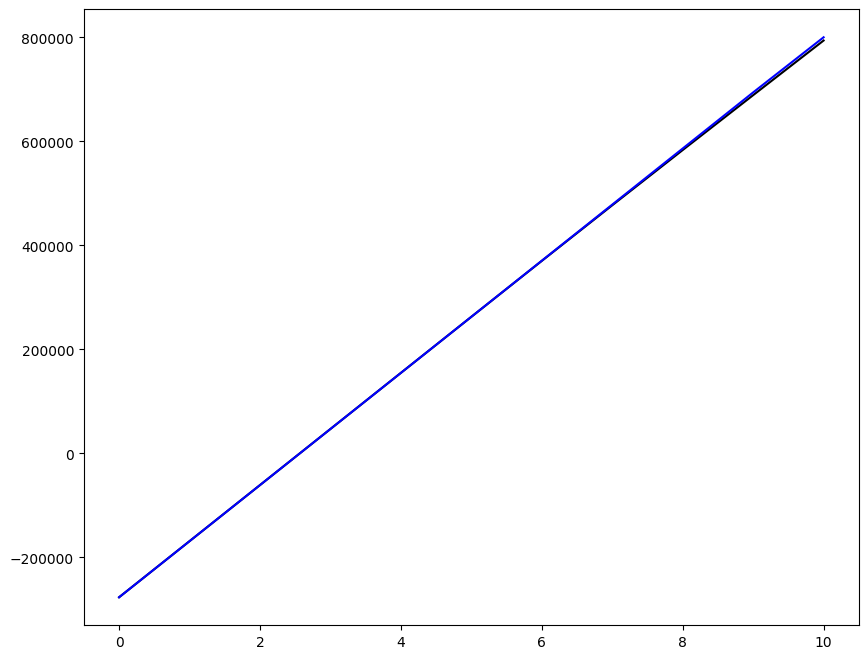

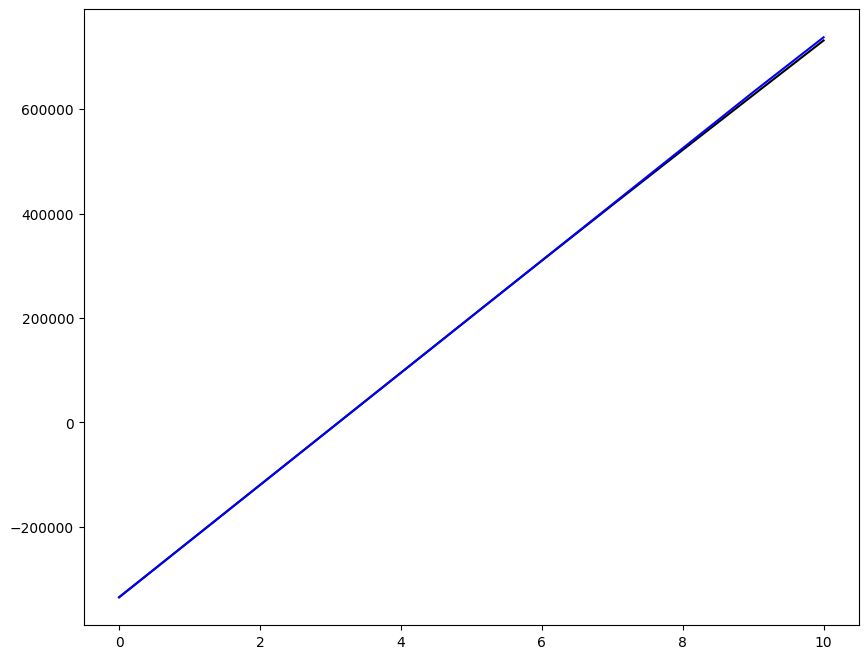

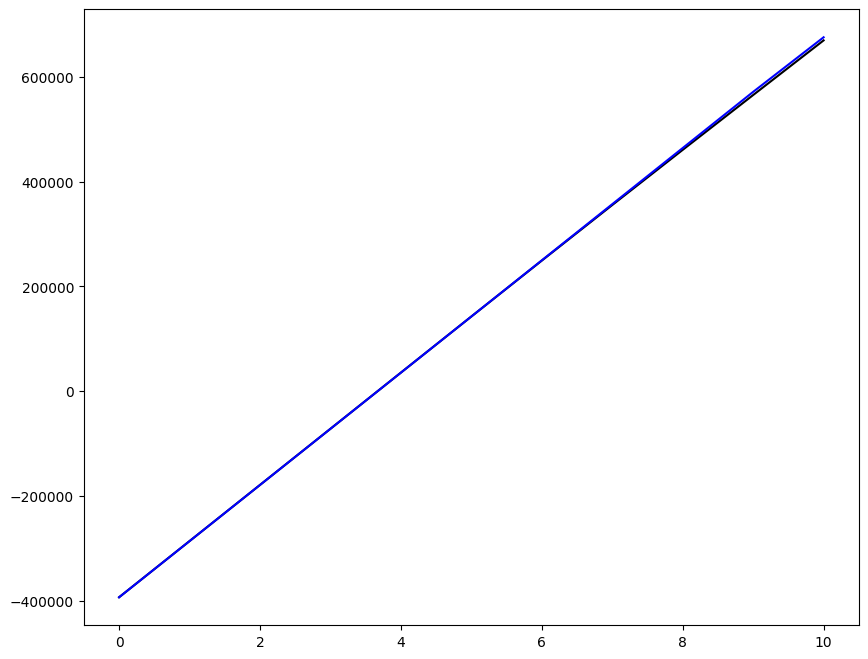

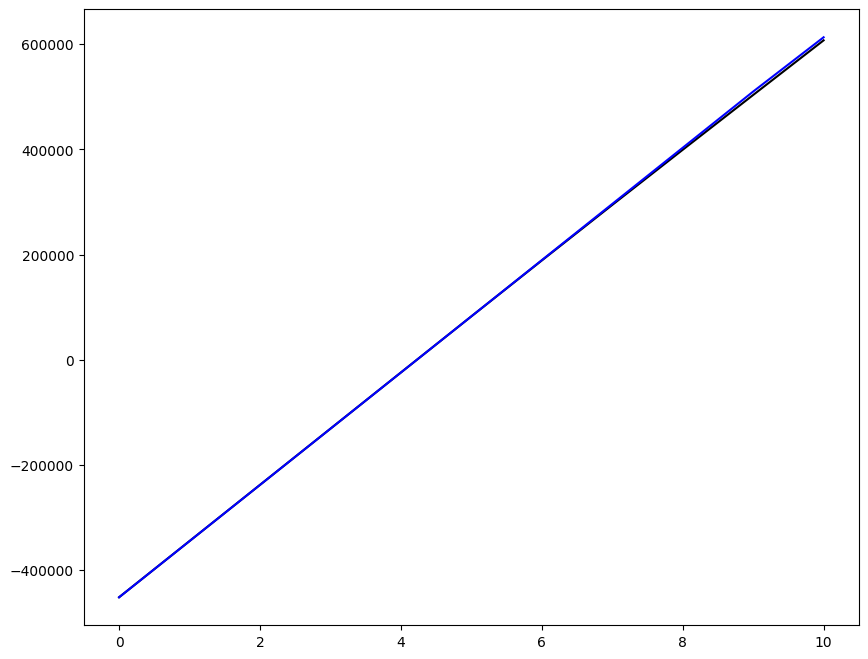

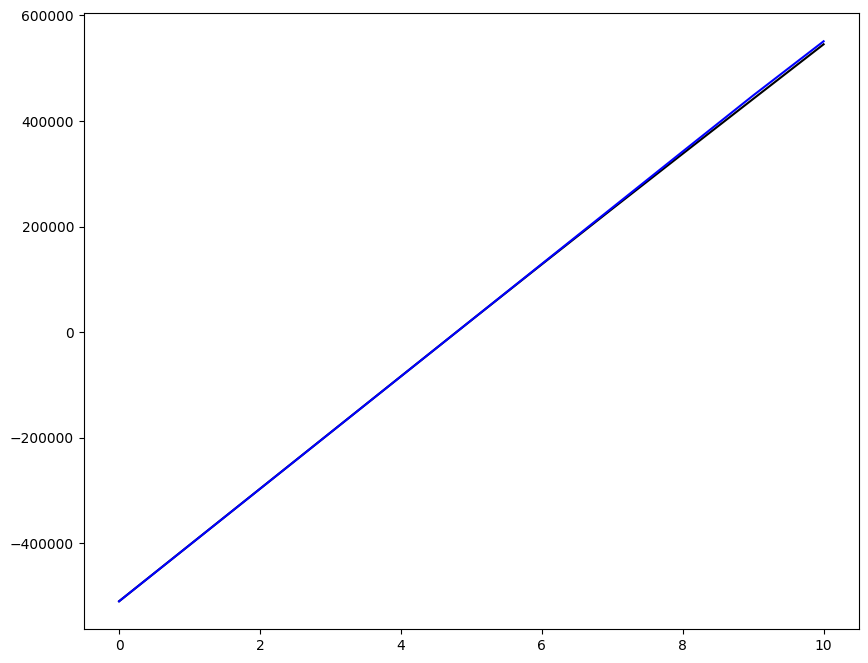

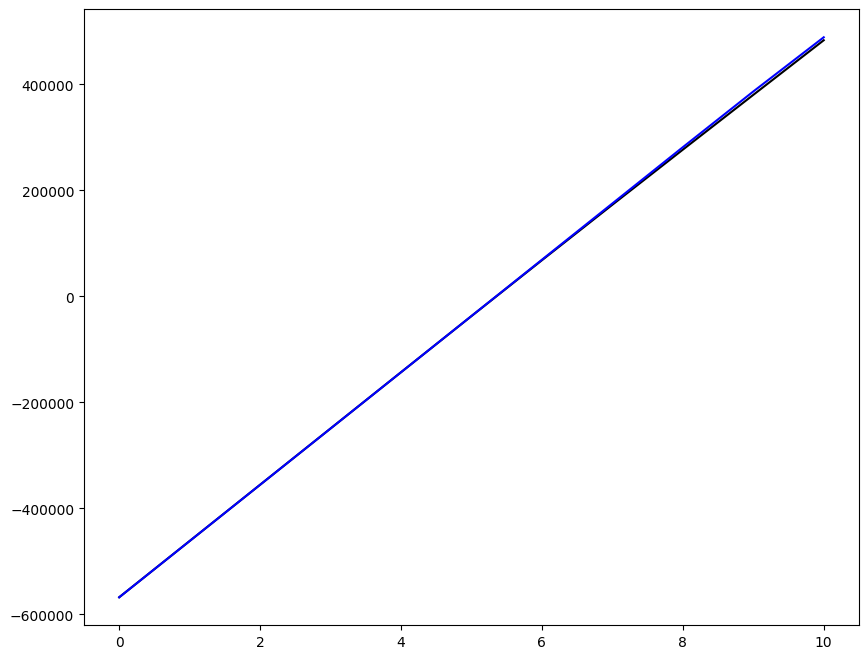

In [7]:
n = 5
for i_T in range(10):
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
    # fig, ax2 = plt.subplots(1,1,figsize=(10,8))
    # fig, ax3 = plt.subplots(1,1,figsize=(10,8))
    for i, dp in zip((3,), ("-",)):
        # for i, dp in enumerate(("-", "--", "-.", "-..", "-","-.")):
        ax1.plot(fans_S[i_T][n][:, 0], dp, color="black")
        # ax1.plot( (fans_S[i_T][n][:,i]-ntfa_S[i_T][n][:,i])/1e3, dp, color='black' )
        # print(fans_S[i_T][n][:,i]-ntfa_S[i_T][n][:,i])
        ax1.plot(ntfa_S[i_T][n][:, 0], dp, color="blue")
        # ax1.plot( ntfa_q[i_T][n][:], '-', color='red', lw=2)
        # ax2.plot( fans_S0[i_T][n][:,i], dp, color='black' )
        # ax2.plot( ntfa_S0[i_T][n][:,i], dp, color='blue' )
        # ax1.plot( fans_S1[i_T][n][:,i], dp, color='black' )
        # ax1.plot( ntfa_S1[i_T][n][:,i], dp, color='blue' )
# ## Plot relative error (NTFA vs. reference)
#
# ### Overall stress

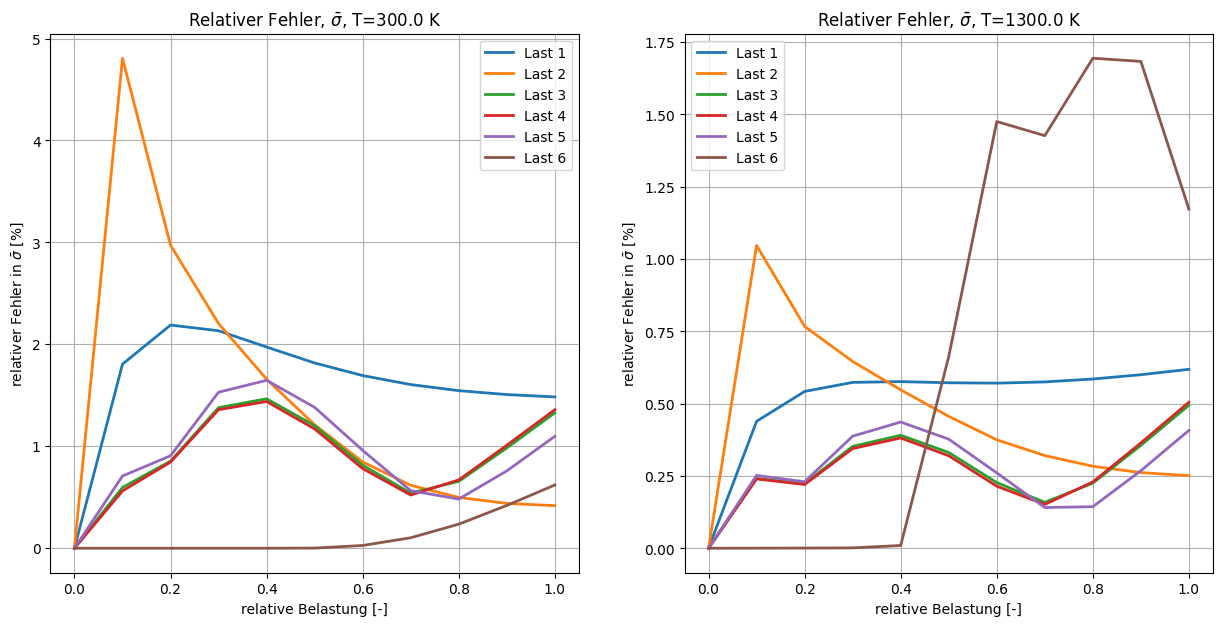

In [8]:
fig, axx = plt.subplots(1, 2, figsize=(15, 7))
ct = 0
for i_T, T in zip((0, 9), (300.0, 1300.0)):
    ax = axx[ct]
    ct += 1
    ax.set_title(r"Relativer Fehler, $\bar{\sigma}$, T=%.1f K" % T)
    x = np.linspace(0, 1, 11)
    ax.set_xlabel("relative Belastung [-]")
    ax.set_ylabel(r"relativer Fehler in $\bar{\sigma}$ [%]")
    for n in range(6):
        myerr = (
            np.linalg.norm(fans_S[i_T][n][:, :] - ntfa_S[i_T][n][:, :], axis=1)
            * 100.0
            / np.linalg.norm(fans_S[i_T][n][:, :], axis=1)
        )
        ax.plot(x, myerr, lw=2, label=f"Last {n + 1}")
        # print(np.max(myerr))
    ax.legend()
    ax.grid()
    # fig.savefig( f'rel_error_ms9p_T{T:.0f}.pdf', format='pdf', pad_inches=0.0)
plt.savefig("rel_err_sig_10s.pdf", format="pdf")
# ### Stress in phase 1 (WSC)

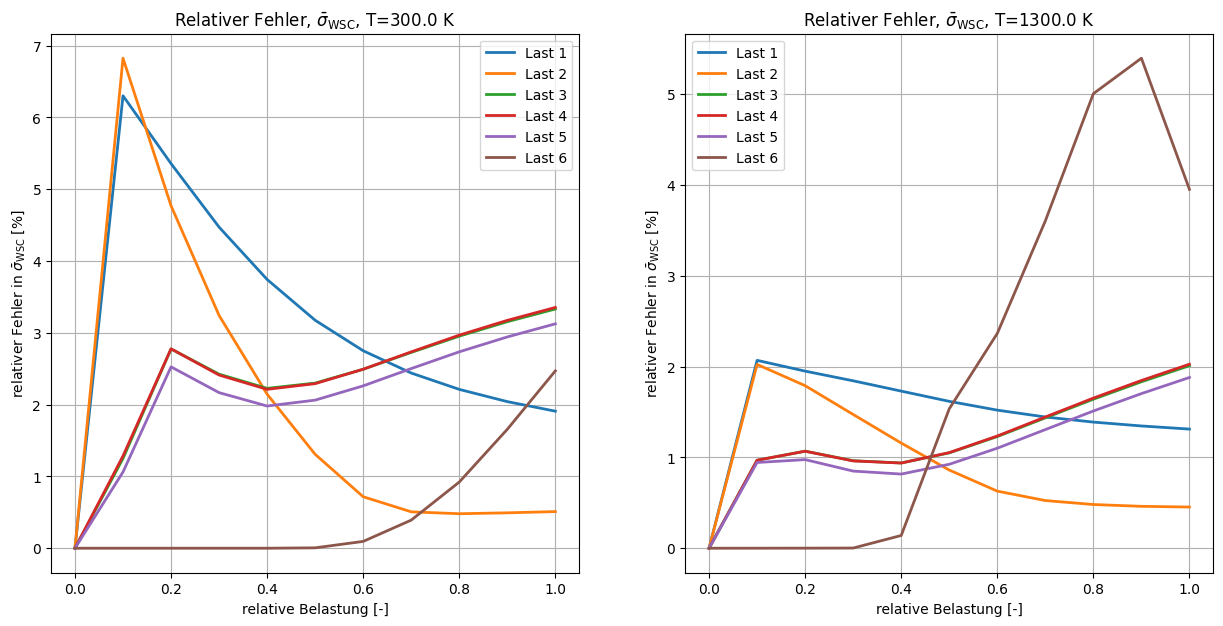

In [9]:
fig, axx = plt.subplots(1, 2, figsize=(15, 7))
ct = 0
for i_T, T in zip((0, 9), (300.0, 1300.0)):
    ax = axx[ct]
    ct += 1
    ax.set_title(r"Relativer Fehler, $\bar{\sigma}_{\rm WSC}$, T=%.1f K" % T)
    x = np.linspace(0, 1, 11)
    ax.set_xlabel("relative Belastung [-]")
    ax.set_ylabel(r"relativer Fehler in $\bar{\sigma}_{\sf WSC}$ [%]")
    for n in range(6):
        myerr = (
            np.linalg.norm(fans_S1[i_T][n][:, :] - ntfa_S1[i_T][n][:, :], axis=1)
            * 100.0
            / np.linalg.norm(fans_S1[i_T][n][:, :], axis=1)
        )
        # myerr[0] = 0.
        ax.plot(x, myerr, lw=2, label=f"Last {n + 1}")
    ax.legend()
    ax.grid()
    # fig.savefig( f'rel_error_ms9p_T{T:.0f}.pdf', format='pdf', pad_inches=0.0)
plt.savefig("rel_err_sig_wsc_10s.pdf", format="pdf")

## Save all results to H5 file

In [10]:
F = h5py.File(
    os.path.join(data_path, "results", "all_results_ms9p_16x16x16_100s_N24.h5"), "w"
)

F.create_dataset("/eps", data=ntfa_eps)
F.create_group("/ntfa")
F.create_group("/fans")
F.create_dataset("/temperature", data=np.array(temp_list))
F.create_dataset("/fans/sig", data=fans_S)
F.create_dataset("/fans/sig0", data=fans_S0)
F.create_dataset("/fans/sig1", data=fans_S1)
F.create_dataset("/ntfa/sig", data=ntfa_S)
F.create_dataset("/ntfa/sig0", data=ntfa_S0)
F.create_dataset("/ntfa/sig1", data=ntfa_S1)
F.create_dataset("/ntfa/q", data=ntfa_q)
F.create_dataset("/ntfa/xi", data=ntfa_xi)

F.close()

In [11]:
# fans_E = np.array(F["ms_9p/dset0_sim/loadcases_0300.00"])[:,20:30]
# fans_S = np.array(F["ms_9p/dset0_sim/hom_response_0300.00"])[:,20:30]
# fans_S0 = np.array(F["ms_9p/dset0_sim/hom_response0_0300.00"])[:,20:30]
# fans_S1 = np.array(F["ms_9p/dset0_sim/hom_response1_0300.00"])[:,20:30]
# F.close()
# fname = "/home/fritzen/calc/dvs/NTFAthermo_paper/ntfa_hull_res.h5"
# F = h5py.File(fname, "r")
# ntfa_E = np.array(F["eps"])
# ntfa_S = np.array(F["sig"])
# ntfa_S0 = np.array(F["sig0"])
# ntfa_S1 = np.array(F["sig1"])
# F.close()

# #%%
# fig, ax = plt.subplots(1,3,figsize=(20,6))
# icomp = 3
# ax[0].plot(fans_E[icomp,:], fans_S[icomp,:], 'x-', color='black')
# ax[0].plot(ntfa_E[icomp,:], ntfa_S[icomp,:], 'o-', color='blue')
# ax[1].plot(fans_E[icomp,:], fans_S0[icomp,:],'x-',  color='black')
# ax[1].plot(ntfa_E[icomp,:], ntfa_S0[icomp,:], 'o-', color='blue')
# ax[2].plot(fans_E[icomp,:], fans_S1[icomp,:], 'x-', color='black')
# ax[2].plot(ntfa_E[icomp,:], ntfa_S1[icomp,:], 'o-', color='blue')

# fig, ax = plt.subplots(1,1)
# ax.plot(fans_E[icomp,:3], fans_S[icomp,:3],'x-',  color='black')
# ax.plot(ntfa_E[icomp,:20], ntfa_S[icomp,:20], 'o-', color='blue')